<a href="https://colab.research.google.com/github/ShoaibSheriff/Computer-Vision/blob/master/SIFT%20%26%20HOG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# import packages here
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

In [0]:
cv2.__version__

'3.3.0'

## Match images using SIFT features


Transformation Matrix = 
[[  1.73855890e-01  -9.84786680e-01   3.23327786e+02]
 [  9.85395567e-01   1.74094203e-01  -6.49129012e+01]
 [  6.54761095e-07   1.66967225e-06   1.00000000e+00]]


(-0.5, 399.5, 319.5, -0.5)

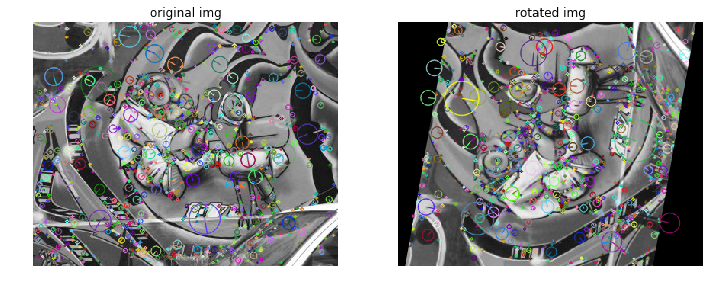

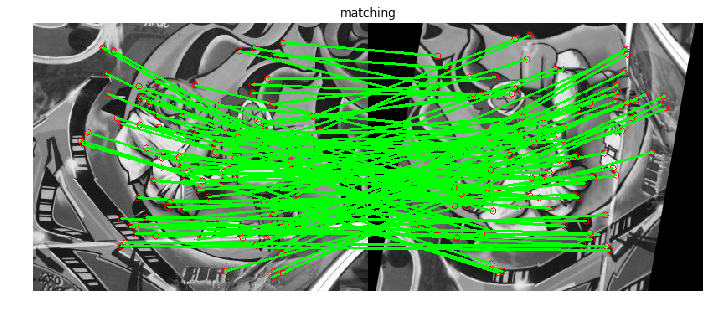

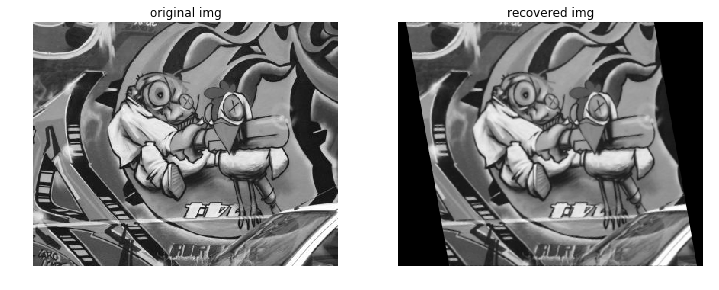

In [0]:
def drawMatches(img1, kp1, img2, kp2, matches):

    # Create a new output image that concatenates the two images together
    # (a.k.a) a montage
    rows1 = img1.shape[0]
    cols1 = img1.shape[1]
    rows2 = img2.shape[0]
    cols2 = img2.shape[1]

    # Create the output image
    # The rows of the output are the largest between the two images
    # and the columns are simply the sum of the two together
    # The intent is to make this a colour image, so make this 3 channels
    out = np.zeros((max([rows1,rows2]),cols1+cols2,3), dtype='uint8')

    # Place the first image to the left
    out[:rows1,:cols1] = np.dstack([img1, img1, img1])

    # Place the next image to the right of it
    out[:rows2,cols1:] = np.dstack([img2, img2, img2])

    # For each pair of points we have between both images
    # draw circles, then connect a line between them
    for mat in matches:

        # Get the matching keypoints for each of the images
        img1_idx = mat[0].queryIdx
        img2_idx = mat[0].trainIdx

        # x - columns
        # y - rows
        (x1,y1) = kp1[img1_idx].pt
        (x2,y2) = kp2[img2_idx].pt

        # Draw a small circle at both co-ordinates
        # radius 4
        # colour blue
        # thickness = 1
        cv2.circle(out, (int(x1),int(y1)), 4, (255, 0, 0), 1)   
        cv2.circle(out, (int(x2)+cols1,int(y2)), 4, (255, 0, 0), 1)

        # Draw a line in between the two points
        # thickness = 1
        # colour blue
        cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (0,255,0), 2)

    # Also return the image if you'd like a copy
    return out


# Read image
img_input = cv2.imread('SourceImages/sift_input.jpg', 0)

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1,des1 = sift.detectAndCompute(img_input,None)

temp = np.zeros_like(img_input)
# Draw keypoints on the image
# ===== This is your first output =====
res1 = cv2.drawKeypoints(img_input, kp1, temp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


############# Without padding

# # # rotate image
height,width = img_input.shape
M = cv2.getRotationMatrix2D((width/2,height/2),80,1)
img_input_rotated = cv2.warpAffine(img_input,M,(width,height))


# # # find the keypoints and descriptors on the rotated image
kp2,des2 = sift.detectAndCompute(img_input_rotated,None)

# temp = np.zeros_like(img_input)
# # # Draw keypoints on the rotated image
# # # ===== This is your second output =====
res2 = cv2.drawKeypoints(img_input_rotated, kp2, temp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)



# # ====== Plot functions, DO NOT CHANGE =====
# Plot result images
plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.imshow(res1, 'gray')
plt.title('original img')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(res2, 'gray')
plt.title('rotated img')
plt.axis('off')


# # ==========================================

# # # compute feature matching
# # BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

# # Apply ratio test
good_matches = [] # Append filtered matches to this list
for m,n in matches:
    if m.distance < 0.1*n.distance:
        good_matches.append([m])

# # draw matching results with the given drawMatches function
# # ===== This is your third output =====
# res3 = cv2.drawMatchesKnn(res1,kp1,res2,kp2,good_matches,temp)
res3 = drawMatches(img_input,kp1,img_input_rotated,kp2, good_matches)


# # ====== Plot functions, DO NOT CHANGE =====
plt.figure(figsize=(12,8))
plt.imshow(res3)
plt.title('matching')
plt.axis('off')
# # # ==========================================


# # # # # estimate similarity transform
if len(good_matches) > 4:
    
    src_pts = np.float32([kp2[m[0].trainIdx].pt for m in good_matches])
    dst_pts = np.float32([kp1[m[0].queryIdx].pt for m in good_matches])
    
    # find perspective transform matrix using RANSAC
    rot, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC)
    print "Transformation Matrix = \n", rot
    
    # mapping rotated image back with the calculated rotation matrix
    # ===== This is your fourth output =====
    res4 = cv2.warpPerspective(img_input_rotated, rot, (img_input.shape[1],img_input.shape[0]))
else:
    print "Not enough matches are found - %d/%d" % (len(good_matches),4)

# # ====== Plot functions, DO NOT CHANGE =====
# plot result images
plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.imshow(img_input, 'gray')
plt.title('original img')
plt.axis('off')
    
plt.subplot(1, 2, 2)
plt.imshow(res4, 'gray')
plt.title('recovered img')  
plt.axis('off')
# # ==========================================

## With Padding

Transformation Matrix = 
[[  1.73570316e-01  -9.84789907e-01   4.08127892e+02]
 [  9.84838537e-01   1.73663345e-01  -1.36617347e+02]
 [ -1.33163141e-08  -7.89571637e-09   1.00000000e+00]]


(-0.5, 399.5, 319.5, -0.5)

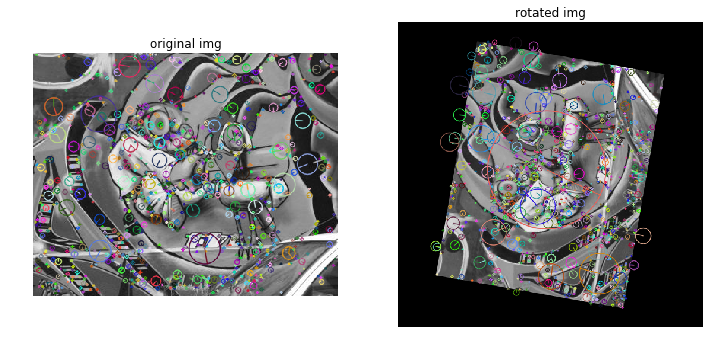

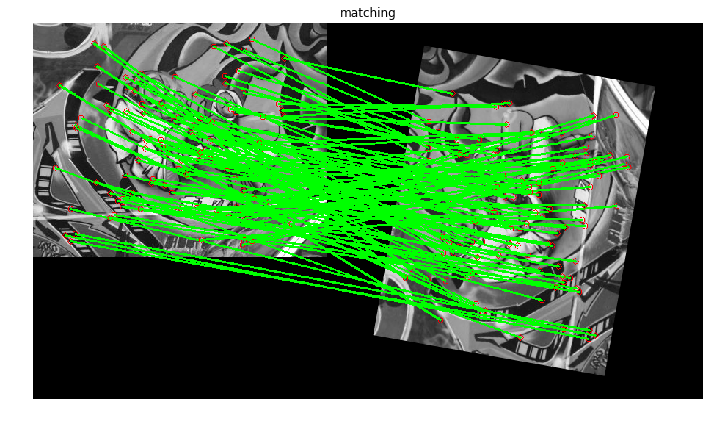

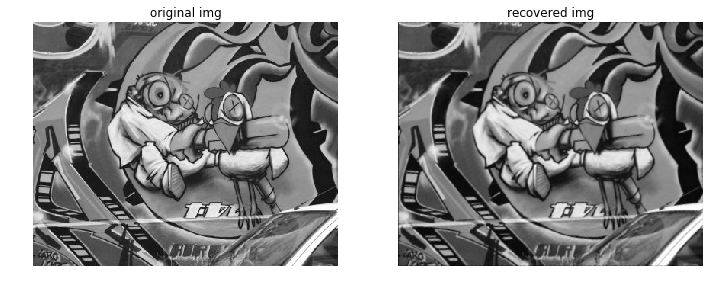

In [0]:
def drawMatches(img1, kp1, img2, kp2, matches):
    """
    My own implementation of cv2.drawMatches as OpenCV 2.4.9
    does not have this function available but it's supported in
    OpenCV 3.0.0

    This function takes in two images with their associated 
    keypoints, as well as a list of DMatch data structure (matches) 
    that contains which keypoints matched in which images.

    An image will be produced where a montage is shown with
    the first image followed by the second image beside it.

    Keypoints are delineated with circles, while lines are connected
    between matching keypoints.

    img1,img2 - Grayscale images
    kp1,kp2 - Detected list of keypoints through any of the OpenCV keypoint 
              detection algorithms
    matches - A list of matches of corresponding keypoints through any
              OpenCV keypoint matching algorithm
    """

    # Create a new output image that concatenates the two images together
    # (a.k.a) a montage
    rows1 = img1.shape[0]
    cols1 = img1.shape[1]
    rows2 = img2.shape[0]
    cols2 = img2.shape[1]

    # Create the output image
    # The rows of the output are the largest between the two images
    # and the columns are simply the sum of the two together
    # The intent is to make this a colour image, so make this 3 channels
    out = np.zeros((max([rows1,rows2]),cols1+cols2,3), dtype='uint8')

    # Place the first image to the left
    out[:rows1,:cols1] = np.dstack([img1, img1, img1])

    # Place the next image to the right of it
    out[:rows2,cols1:] = np.dstack([img2, img2, img2])

    # For each pair of points we have between both images
    # draw circles, then connect a line between them
    for mat in matches:

        # Get the matching keypoints for each of the images
        img1_idx = mat[0].queryIdx
        img2_idx = mat[0].trainIdx

        # x - columns
        # y - rows
        (x1,y1) = kp1[img1_idx].pt
        (x2,y2) = kp2[img2_idx].pt

        # Draw a small circle at both co-ordinates
        # radius 4
        # colour blue
        # thickness = 1
        cv2.circle(out, (int(x1),int(y1)), 4, (255, 0, 0), 1)   
        cv2.circle(out, (int(x2)+cols1,int(y2)), 4, (255, 0, 0), 1)

        # Draw a line in between the two points
        # thickness = 1
        # colour blue
        cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (0,255,0), 2)

    # Also return the image if you'd like a copy
    return out


# Read image
img_input = cv2.imread('SourceImages/sift_input.jpg', 0)

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1,des1 = sift.detectAndCompute(img_input,None)

# Draw keypoints on the image
# ===== This is your first output =====
temp = np.zeros_like(img_input)
res1 = cv2.drawKeypoints(img_input, kp1, temp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


#diagonal
max_size = int(math.ceil(np.sqrt(np.square(img_input.shape[0]) + np.square(img_input.shape[1]))))
image_with_padding = np.zeros((max_size, max_size), dtype='uint8')

x_offset = (max_size - img_input.shape[0]) / 2
y_offset = (max_size - img_input.shape[1]) / 2

image_with_padding[x_offset:(x_offset + img_input.shape[0]), y_offset:(y_offset + img_input.shape[1])] = img_input

# # # rotate image
height,width = image_with_padding.shape
M = cv2.getRotationMatrix2D((width/2,height/2),80,1)
img_input_rotated = cv2.warpAffine(image_with_padding,M,(width,height))


# # # find the keypoints and descriptors on the rotated image
kp2,des2 = sift.detectAndCompute(img_input_wp_rotated,None)

# # # Draw keypoints on the rotated image
# # # ===== This is your second output =====
temp = np.zeros_like(img_input_wp_rotated)
res2 = cv2.drawKeypoints(img_input_wp_rotated, kp2, temp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# # ====== Plot functions, DO NOT CHANGE =====
# Plot result images
plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.imshow(res1, 'gray')
plt.title('original img')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(res2, 'gray')
plt.title('rotated img')
plt.axis('off')


# # ==========================================

# # # compute feature matching
# # BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

# # Apply ratio test
good_matches = [] # Append filtered matches to this list
for m,n in matches:
    if m.distance < 0.1*n.distance:
        good_matches.append([m])

# # draw matching results with the given drawMatches function
# # ===== This is your third output =====
# res3 = cv2.drawMatchesKnn(res1,kp1,res2,kp2,good_matches,temp)
res3 = drawMatches(img_input,kp1,img_input_rotated,kp2, good_matches)


# # ====== Plot functions, DO NOT CHANGE =====
plt.figure(figsize=(12,8))
plt.imshow(res3)
plt.title('matching')
plt.axis('off')
# # # ==========================================


# # # # # estimate similarity transform
if len(good_matches) > 4:
    
    src_pts = np.float32([kp2[m[0].trainIdx].pt for m in good_matches])
    dst_pts = np.float32([kp1[m[0].queryIdx].pt for m in good_matches])
    
    # find perspective transform matrix using RANSAC
    rot, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC)
    print "Transformation Matrix = \n", rot
    
    # mapping rotated image back with the calculated rotation matrix
    # ===== This is your fourth output =====
    res4 = cv2.warpPerspective(img_input_rotated, rot, (img_input.shape[1],img_input.shape[0]))
else:
    print "Not enough matches are found - %d/%d" % (len(good_matches),4)

# # ====== Plot functions, DO NOT CHANGE =====
# plot result images
plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.imshow(img_input, 'gray')
plt.title('original img')
plt.axis('off')
    
plt.subplot(1, 2, 2)
plt.imshow(res4, 'gray')
plt.title('recovered img')  
plt.axis('off')
# # ==========================================

## Scene stitching with SIFT features

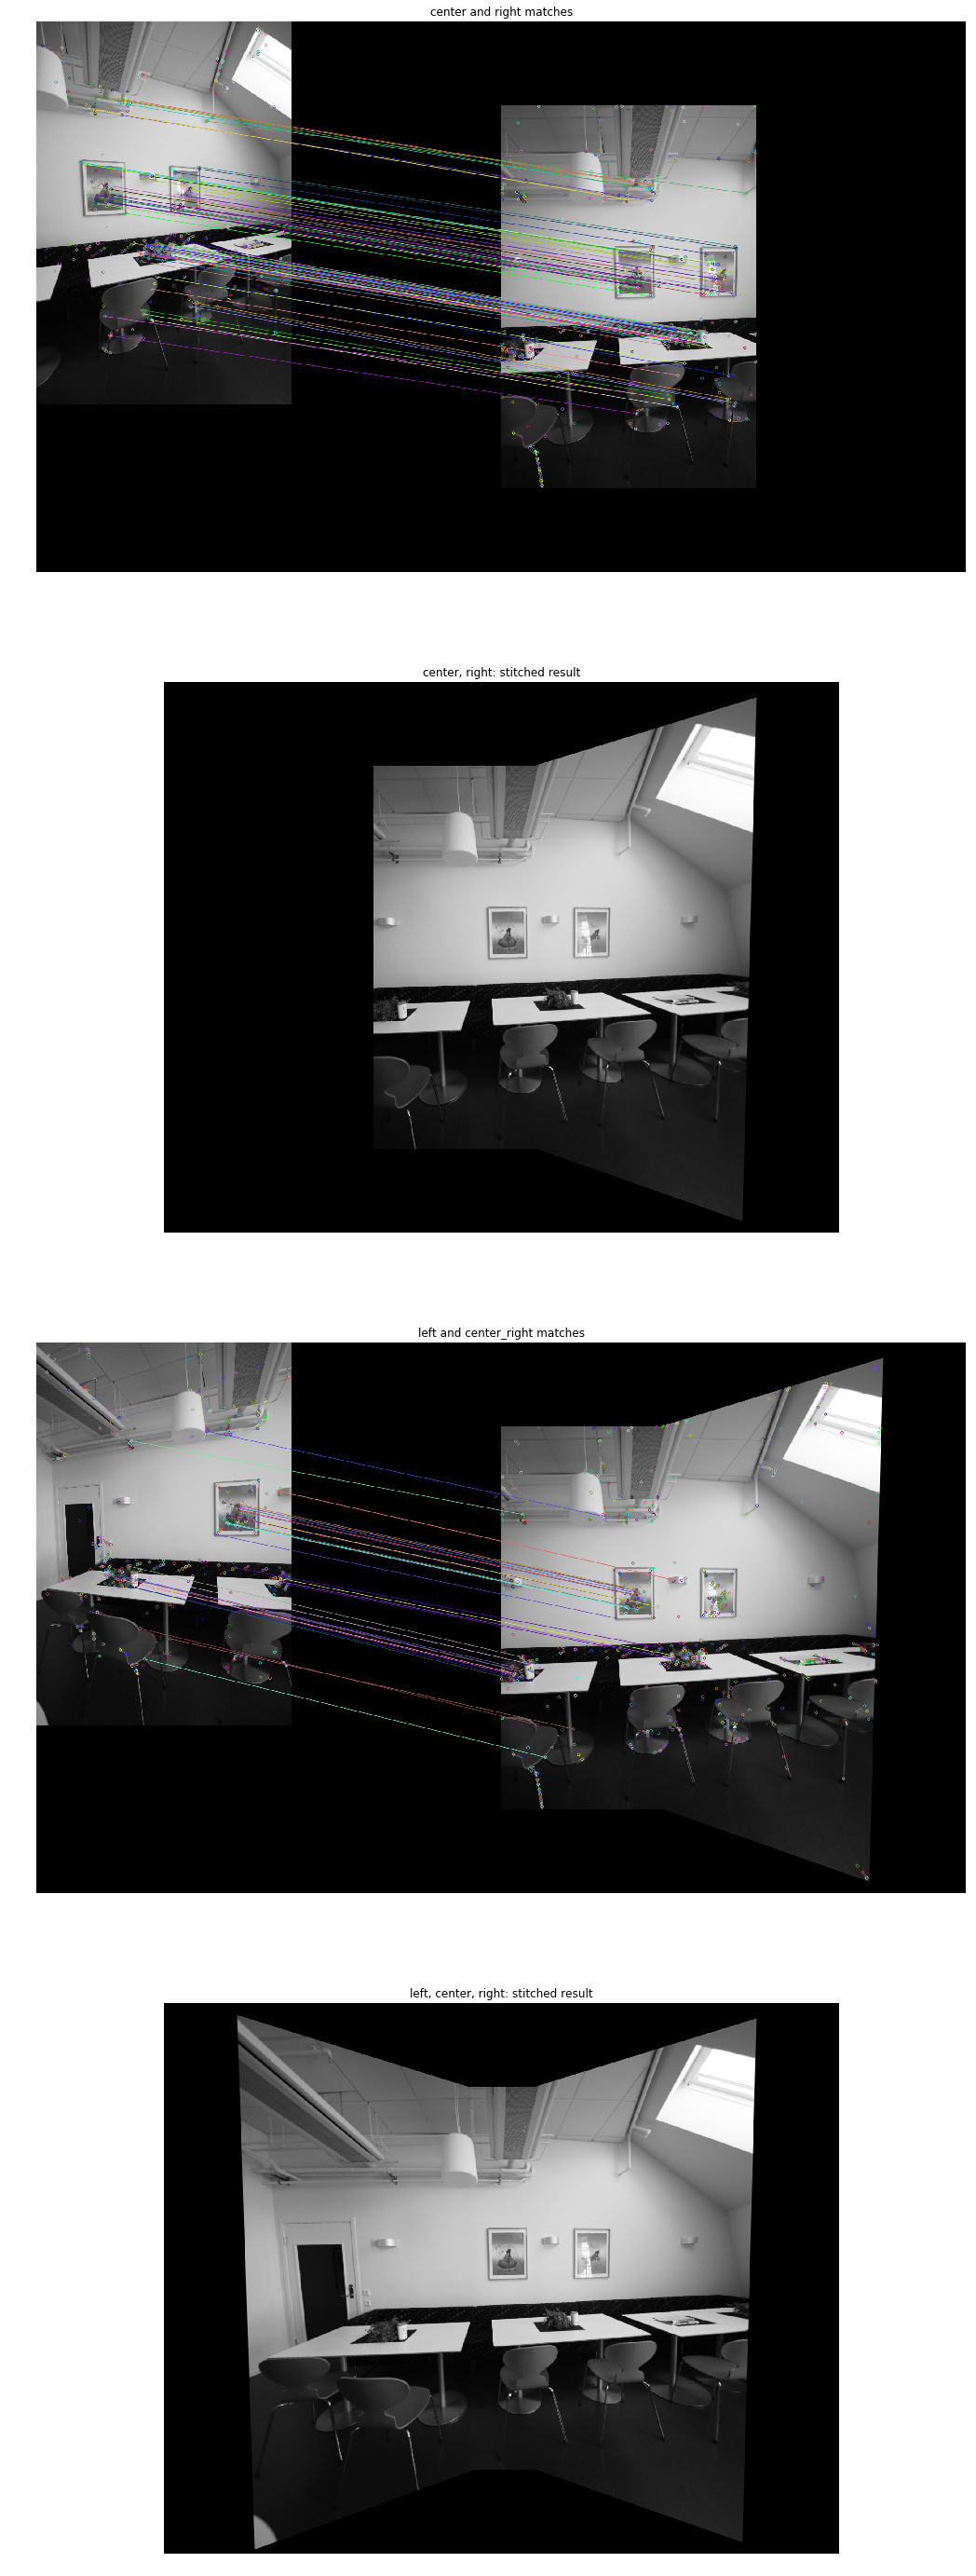

(-0.5, 1607.5, 1311.5, -0.5)

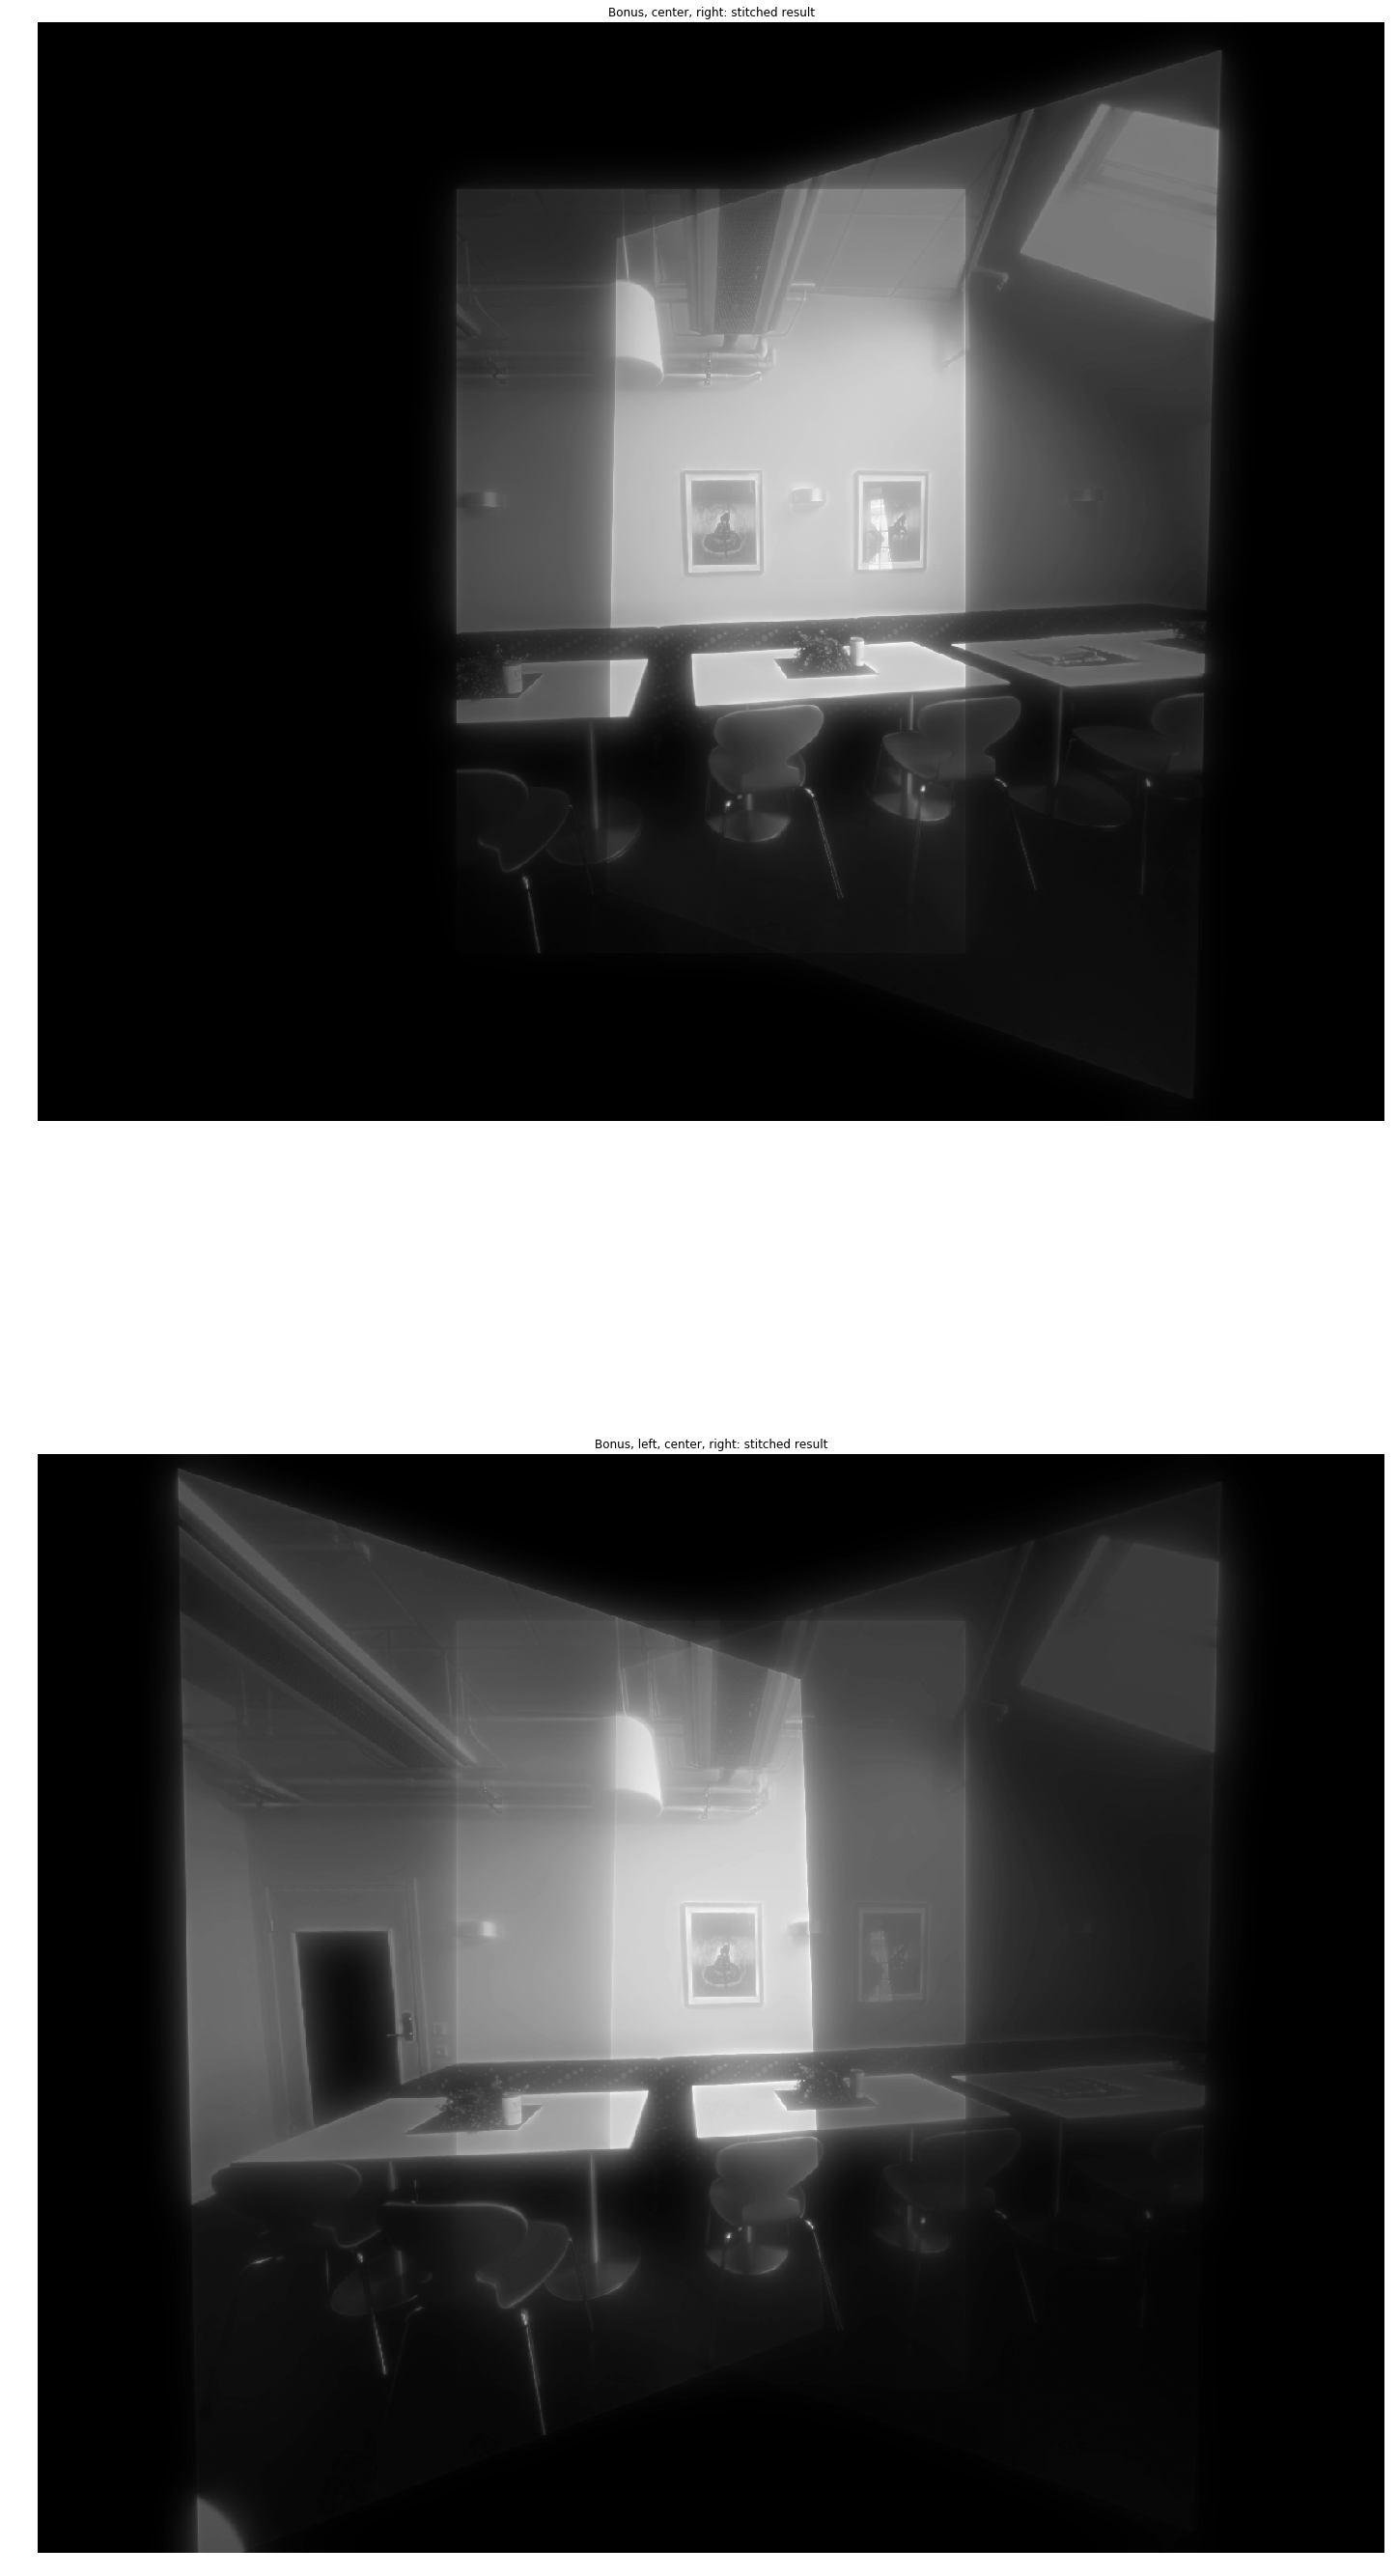

In [0]:
imgCenter = cv2.imread('SourceImages/stitch_m.png', 0)
imgRight  = cv2.imread('SourceImages/stitch_r.png', 0)
imgLeft   = cv2.imread('SourceImages/stitch_l.png', 0)

# initalize the stitched image as the center image
imgCenter = cv2.copyMakeBorder(imgCenter,200,200,500,500,cv2.BORDER_CONSTANT)

# # #laplacian blending mask
# mask_laplacian_blending_1 = np.ones((imgRight.shape[0], imgRight.shape[1]/4), dtype='float32')
# mask_laplacian_blending_0 = np.zeros((imgRight.shape[0], imgRight.shape[1]/4), dtype='float32')
# mask_laplacian_blending = np.hstack([mask_laplacian_blending_1, mask_laplacian_blending_0])
# mask_laplacian_blending = cv2.copyMakeBorder(mask_laplacian_blending,200,200,500 + imgRight.shape[1]/4,500 + imgRight.shape[1]/4,cv2.BORDER_CONSTANT, value  = 0)

# laplacian blending mask
mask_laplacian_blending_1 = np.ones((imgRight.shape[0], imgRight.shape[1]/2), dtype='float32')
mask_laplacian_blending_0 = np.zeros((imgRight.shape[0], imgRight.shape[1]/2), dtype='float32')
mask_laplacian_blending = np.hstack([mask_laplacian_blending_1, mask_laplacian_blending_0])
mask_laplacian_blending = cv2.copyMakeBorder(mask_laplacian_blending,200,200,500,500,cv2.BORDER_CONSTANT, value  = 0)


# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# blend two images
def alpha_blend(img, warped):
    
    # Implement alpha_blending
    blended = cv2.max(img, warped)  
    return blended

def Laplacian_Blending(A, B, m, num_levels=6):
    
    # generate Gaussian pyramid for A    
    G = A.copy()
    gpA = [G]
    for i in range(num_levels):
        G = cv2.pyrDown(G)
        gpA.append(G)
        
    # generate Gaussian pyramid for B
    G = B.copy()
    gpB = [G]
    for i in range(num_levels):
        G = cv2.pyrDown(G)
        gpB.append(G)
        
    # generate Gaussian pyramid for mask
    G = m.copy()
    gpM = [G]
    for i in range(num_levels):
        G = cv2.pyrDown(G)
        gpM.append(G)
        

   # generate Laplacian Pyramid for A
    lpA = [gpA[num_levels - 1]]
    for i in range(num_levels - 1,0,-1):
        size = (gpA[i-1].shape[1], gpA[i-1].shape[0])
        GE = cv2.pyrUp(gpA[i], dstsize = size)
        L = cv2.subtract(gpA[i-1],GE)
        lpA.append(L)
    
    # generate Laplacian Pyramid for B        
    lpB = [gpB[num_levels - 1]]
    for i in range(num_levels - 1,0,-1):
        size = (gpB[i-1].shape[1], gpB[i-1].shape[0])
        GE = cv2.pyrUp(gpB[i], dstsize = size)
        L = cv2.subtract(gpB[i-1],GE)
        lpB.append(L) 
        
    # generate Laplacian Pyramid for mask     
    lpM = [gpM[num_levels - 1]]
    for i in range(num_levels - 1,0,-1):
        size = (gpM[i-1].shape[1], gpM[i-1].shape[0])
        GE = cv2.pyrUp(gpM[i], dstsize = size)
        L = cv2.subtract(gpM[i-1],GE)
        L = np.fliplr([L.T])[0].T #flip mask
        lpM.append(L) 
    
    
    LS = []
    for la,lb,gm in zip(lpA,lpB,lpM):
#         ls = np.multiply(la, gm) + np.multiply(lb, (1.0 - gm)) bad result
#         ls = cv2.max(la, lb) bad result
        ls = la * 0.4 + lb * 0.4
        LS.append(ls)
        
    # now reconstruct
    ls_ = LS[0]
    for i in range(1,num_levels):
        size = (LS[i].shape[1], LS[i].shape[0])
        ls_ = cv2.pyrUp(ls_, dstsize = size)
        ls_ = cv2.add(ls_, LS[i])
    
    blended = ls_
    
    return blended.astype('uint8')

def getTransform(img_src, img_dest, ratio):
    
    # compute sift descriptors
    kp_s,des_s = sift.detectAndCompute(img_src,None)
    kp_d,des_d = sift.detectAndCompute(img_dest,None)

    # find all mactches
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des_s,des_d, k=2)

    # # Apply ratio test
    good_matches = [] # Append filtered matches to this list
    for m,n in matches:
        if m.distance < ratio * n.distance:
            good_matches.append([m])
            
    if (len(good_matches) < 4) :
        print('Not enough matches')

    temp = np.zeros_like(img_dest, dtype='uint8')
    
    # draw matches
    img_match = cv2.drawMatchesKnn(img_src,kp_s,img_dest,kp_d,good_matches,temp)
    

    # estimate transform matrix using RANSAC
    src_pts = np.float32([kp_s[m[0].queryIdx].pt for m in good_matches])
    dst_pts = np.float32([kp_d[m[0].trainIdx].pt for m in good_matches])
        
    # find perspective transform matrix using RANSAC
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC)     
    
    return H, img_match, mask

def perspective_warping(imgCenter, imgLeft, imgRight):
    
    # Get homography from right to center
    # ===== img_match1 is your first output =====
    # call getTransform to get the transformation from the right to the center image
    T_R2C, img_match1, mask = getTransform(imgRight, imgCenter, 0.3)
    
    warped_right = cv2.warpPerspective(imgRight, T_R2C, (imgCenter.shape[1], imgCenter.shape[0]))
    
    # Blend center and right
    # ===== stitched_cr is your second output =====
    stitched_cr = alpha_blend(imgCenter, warped_right)
    
    # Get homography from left to stitched center_right
    # ===== img_match2 is your third output =====
    # call getTransform to get the transformation from the left to stitched_cr
    T_L2CR, img_match2, mask = getTransform(imgLeft, stitched_cr, 0.3)
    
    warped_left = cv2.warpPerspective(imgLeft, T_L2CR, (stitched_cr.shape[1], stitched_cr.shape[0]))
    
    # Blend left and center_right
    # ===== stitched_res is your fourth output =====
    stitched_res = alpha_blend(stitched_cr, warped_left)
    
    return stitched_res, stitched_cr, img_match1, img_match2

def perspective_warping_laplacian_blending(imgCenter, imgLeft, imgRight):
    
    # Get homography from right to center
    
    T_R2C, img_match1, mask1 = getTransform(imgRight, imgCenter, 0.55)
    warped_right = cv2.warpPerspective(imgRight, T_R2C, (imgCenter.shape[1], imgCenter.shape[0]))
    
    # Blend center and right
    # ===== This is your first bonus output =====
    stitched_cr = Laplacian_Blending(imgCenter, warped_right, mask_laplacian_blending)
      
    # Get homography from left to stitched center_right
    T_L2CR, img_match2, mask2 = getTransform(imgLeft, stitched_cr, 0.55)
    warped_left = cv2.warpPerspective(imgLeft, T_L2CR, (stitched_cr.shape[1], stitched_cr.shape[0]))
    
    # Blend left and center_right
    # ===== This is your second bonus output =====
    stitched_res = Laplacian_Blending(stitched_cr, warped_left, mask_laplacian_blending)
    
    return stitched_res, stitched_cr


# ====== Plot functions, DO NOT CHANGE =====
stitched_res, stitched_cr, img_match1, img_match2 = perspective_warping(imgCenter, imgLeft, imgRight)
stitched_res_lap, stitched_cr_lap = perspective_warping_laplacian_blending(imgCenter, imgLeft, imgRight)
        
plt.figure(figsize=(25,50))
plt.subplot(4, 1, 1)
plt.imshow(img_match1, cmap='gray')
plt.title("center and right matches")
plt.axis('off')
plt.subplot(4, 1, 2)
plt.imshow(stitched_cr, cmap='gray')
plt.title("center, right: stitched result")
plt.axis('off')
plt.subplot(4, 1, 3)
plt.imshow(img_match2, cmap='gray')
plt.title("left and center_right matches")
plt.axis('off')
plt.subplot(4, 1, 4)
plt.imshow(stitched_res, cmap='gray')
plt.title("left, center, right: stitched result")
plt.axis('off')
plt.show()

plt.figure(figsize=(25,50))
plt.subplot(2, 1, 1)
plt.imshow(stitched_cr_lap, cmap='gray')
plt.title("Bonus, center, right: stitched result")
plt.axis('off')
plt.subplot(2, 1, 2)
plt.imshow(stitched_res_lap, cmap='gray')
plt.title("Bonus, left, center, right: stitched result")
plt.axis('off')
# =============================================

## Object Recognition with HOG features


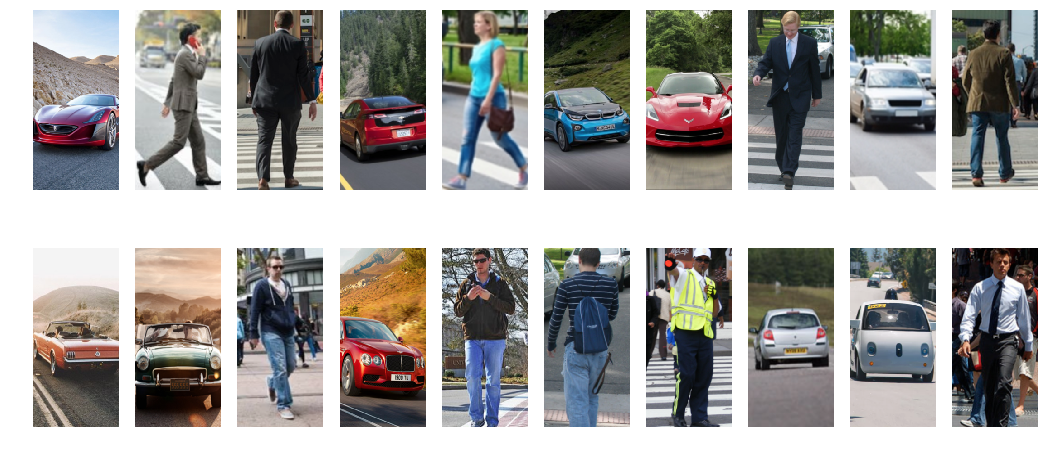

In [0]:
import skimage.exposure
from skimage.feature import hog
from sklearn.svm import LinearSVC
import os
from skimage import io

count = 10

# load data
def loadData(file, count):
    # Implement your loadData(file) here
    
    images = []

    for idx_true in range(count):
        img_name = os.path.join(file + str(idx_true+1) + ".png")
        img = io.imread(img_name)
        images.append(img)
    return images
    

images_car = loadData('SourceImages/human_vs_cars/car_', count)
images_human = loadData('SourceImages/human_vs_cars/human_', count)
images = np.vstack([images_car, images_human])

randomize = np.arange(count * 2)
np.random.shuffle(randomize)

images = images[randomize]
    
# ===== Display your first graph here =====
plt.figure(figsize=(18,8))

for i in range(count) :
    plt.subplot(2, 10, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    
for i in range(count) :
    plt.subplot(2, 10, count + i+1)
    plt.imshow(images[count + i])
    plt.axis('off')

# create a vector of labels
# assume labels: car = 0, human = 1
labels_true = np.hstack([np.zeros(count), np.ones(count)])
labels_true = labels_true.astype('int32')
labels_true = labels_true[randomize]

/home/shoaib/anaconda2/lib/python2.7/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


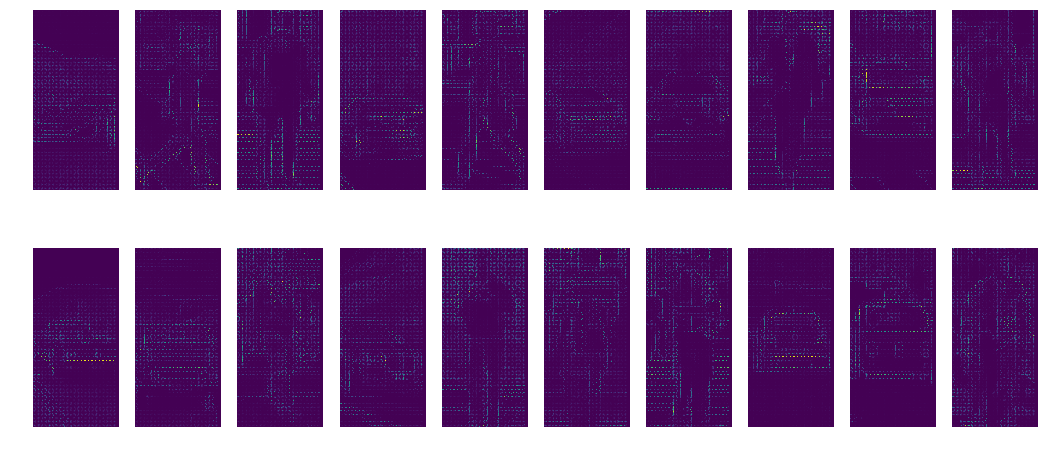

In [0]:
from skimage.color import rgb2gray
from skimage.feature import hog

# Compute HOG features for the images
def computeHOGfeatures(images):
    
    hog_descriptors = np.zeros(shape=(len(images), 81648))
    hog_images = np.zeros(shape = (len(images), 400, 190))
        
    for idx in range(len(images)) :
        
        img_i = images[idx]
        img_g = rgb2gray(img_i)
        vec, hog_image = hog(img_g, visualise=True)
        hog_images[idx] = hog_image
        hog_descriptors[idx, :] = vec   
        
    return hog_descriptors, hog_images

# Compute HOG descriptors
hog_descriptors, hog_images = computeHOGfeatures(images)

# ===== Display your second graph here =====
plt.figure(figsize=(18,8))

for i in range(count) :
    plt.subplot(2, 10, i+1)
    plt.imshow(hog_images[i])
    plt.axis('off')
    
for i in range(count) :
    plt.subplot(2, 10, count + i+1)
    plt.imshow(hog_images[count + i])
    plt.axis('off')

# reshape feature matrix


# # Split the data and labels into train and test set
hog_descriptors_train = hog_descriptors[0 : 16]
labels_true_train = labels_true[0 : 16]

hog_descriptors_test = hog_descriptors[16 : ]
labels_true_test = labels_true[16 : ]

In [0]:
# train model with SVM
# call LinearSVC
# train SVM
# call clf.predict

labels_true_train = labels_true_train.reshape(len(labels_true_train), 1)

svm = cv2.ml.SVM_create()
svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setType(cv2.ml.SVM_C_SVC)
svm.setC(1)
svm.train(np.float32(hog_descriptors_train), cv2.ml.ROW_SAMPLE, labels_true_train)

labels_preds = svm.predict(np.float32(hog_descriptors_test))[1].T.astype('int32')

total_correct_preds = np.sum(labels_preds == labels_true_test)
accuracy = total_correct_preds * 100 / labels_true_test.shape[0]

# # ===== Output functions ======
print('estimated labels: ', labels_preds)
print('ground truth labels: ', labels_true_test)
print('Accuracy: ', accuracy)

('estimated labels: ', array([[1, 0, 0, 1]], dtype=int32))
('ground truth labels: ', array([1, 0, 0, 1], dtype=int32))
('Accuracy: ', 100)
